In [1]:
# Heat transport and temperature
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
Cp = 4220  # Specific heat content J/kg/C
rho = 1025 # Density
ny = 9
T0 = 9 # Initial temperature
Area = np.empty([50, 9])
Area[:10, :] = 100
Area[10:20, :] = 200
Area[20:30, :] = 300
Area[30:40, :] = 800
Area[40:, :] = 1600
ga = np.repeat(np.array([[.5],[1],[1.5],[4],[8]]),10) * 200 * ny # Grid area
#wei = np.repeat(np.array([[.5],[1],[1.5],[4],[8]]),10) / 15 # Weight coefficient for temperature calculation
wi = np.empty([50, 28-3+1])
wi[:10, :] = 0.5 / 150
wi[10:20, :] = 1 / 150
wi[20:30, :] = 1.5 / 150
wi[30:40, :] = 4 / 150
wi[40:, :] = 8 / 150

sd = 15 # sill depth
state01 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/State700/Hs_' + str(format(sd,'03d')) + '.nc')
state02 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/State700/DFx_TH_' + str(format(sd,'03d')) + '.nc')
state1 = state01.isel(Y=range(1,10), T=range(1,121)) # Remove the boundary walls in y direction
state2 = state02.isel(Y=range(1,10), T=range(0,120)) 

Time = state1.T.data
pt = state1.Temp.data # T, Z, Y, X
u = 0.5 * (state1.U.data[:,:,:,:-1] + state1.U.data[:,:,:,1:])
upt = u * (pt)

dfx0 = state2.DFxE_TH.data
dfx = 0.5 * (dfx0[:,:,:,:-1] + dfx0[:,:,:,1:])

In [3]:
theta = pt.mean(2) # Average in Y
Hnet = np.empty(len(Time))
pt_situ = np.empty(len(Time))
for t in range(len(Time)):
    #pvol = pt[t,:,:,3:29]
    #pt_situ[t] = pvol[pvol!=0].mean()
    thetaV = theta[t,:,3:29] * wi / 26
    pt_situ[t] = thetaV[thetaV!=0].sum()
    #thetaV[thetaV!=0] = 1
    mask = np.ma.masked_equal(thetaV, 0)
    V = mask/mask * wi * 150 * 200 * 200 * ny
    #Hnet[t] =  np.sum(pt[t,:,:,3]*Area/(200*150*9))
    Hnet[t] =  np.sum(upt[t,:,:,3]*Area) - np.sum(upt[t,:,:,28] * Area) + np.sum(dfx[t,:,:,3]) - np.sum(dfx[t,:,:,28])
    
Vol = V.sum() # Control volume
dt = Time[1]-Time[0] # Time step

pt_pre = np.empty(len(Time))
pt_pre[0] = pt_situ[0]
for j in range(1,len(Time)):
    deltaT = Hnet[j-1:j+1].mean()*dt/Vol
    pt_pre[j] = pt_pre[j-1] + deltaT

#Hnet

Text(0, 0.5, 'Temperature (°C)')

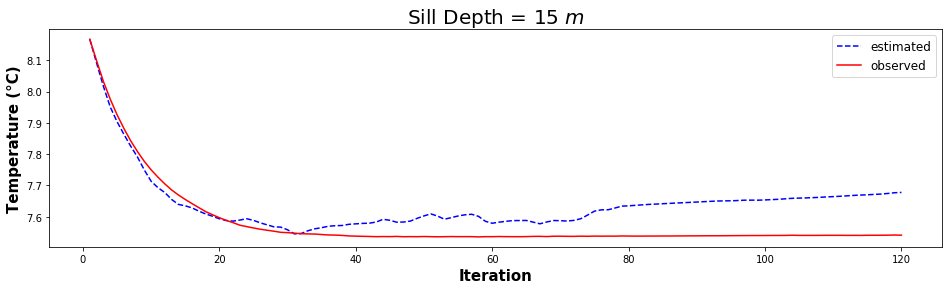

In [4]:
#pvol = pt[:,:,:,3:29]
#pvol[pvol != 0] = 1
#vmask = np.ma.masked_equal(pvol, 0)
#Vol = np.sum(vmask * Area * 200 ) * ny # Control volume

fig, ax = plt.subplots(figsize=(16,4)) 
plt.plot(Time/dt, pt_pre, 'b--', lw=1.5, label='estimated')
plt.plot(Time/dt, pt_situ, 'r-', lw=1.5, label='observed')
plt.legend(loc='best', fontsize=12)
#ax.set_xlim([0,120])
#ax.set_xticks(np.linspace(0,120,13))
#ax.set_xticklabels(np.linspace(0,120,13, dtype = int), size = 15)
plt.title('Sill Depth = '+str(sd)+' $m$', size=20)
plt.xlabel("Iteration", size=15, weight = 'bold')
plt.ylabel("Temperature (\N{DEGREE SIGN}C)", size=15, weight = 'bold')

In [5]:
fig_path = "/Users/weiyangbao/Documents/Jupyter_Figs/Transport/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig.savefig(fig_path + '/EquationH'+str(sd)+'.png', dpi = 150, bbox_inches='tight')